## Machine Learning for Signal Processing 2019/2020 
### Teacher: Danilo Comminiello<br>Exam Project

* **Project title**: Human Activity Recognition using Long Short Term Memory Network.
* **Student(s)**: Emanuele Giacomini 1743995.
* **Reference paper / topic**: Hochreiter & Schmidhuber, Long short-term memory. Neural computation, 1997
* **Starting and delivery dates**: 20 July /

## Part 1: Report

In healthcare and, more specifically, eldercare, the ability to perceive the current user's activity may become essential in assistive tasks. 
By continually tracking the patient's activity, it may be possible to immediately react to critical situations that otherwise could lead to potentially unrecoverable injuries.
The recent growth of Machine Learning led to many approaches to consistently solve the Human Activity Recognition (HAR) problem. In this notebook, one possible solution for  HAR is presented, based on Recurrent Neural Networks and more precisely by adopting an LSTM (Long Short Term Memory) Network.

<img src="./images/LSTM.png">

LSTM, proposed by S. Hochreiter and J. Schmidhuber, is a possible solution to address short-term and long-term information preservation.
An LSTM cell can be seen as an extension of an RU (Recurrent Unit), embedding the recurrent hidden state element for processing short-term information and a memory cell used for long-term storage. Furthermore, the cell contains the set of gates required to control the memory cell:

* Forget Gate
* Input Gate
* Output Gate

The Forget Gate either retains or forgets pieces of information previously stored in the memory cell.
The Input Gate is responsible for deciding which section of the memory cell to update. The Input Gate pairs with an integrated Recurrent Unit, 
which generates potential candidates to store in the memory cell.
Finally, once the memory cell is appropriately updated, the Output Gate decides which portion it should output.

## Part 2: External libraries

First step is to download from __UCI Machine Learning Repository__ the _HAR_ Dataset. 

For the project's purpose, some libraries will be used:
* __TensorFlow__ framework is used to produce the LSTM models that will be further showed.
* __Matplotlib__ for plots
* __Sklearn, Pandas and Seaborn__ are used to produce the confusion matrix

In [1]:
# Download UCI Human Activity Recognition Dataset (UCI HAR)
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -n UCI\ HAR\ Dataset.zip

# Import external required libraries
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
# Decomment the following two rows if tf-gpu is begin used
""""""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
""""""

import numpy as np
from matplotlib import pyplot as plt
# Confusion matrix related imports
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

# Set random seed to determine the networks behaviour
tf.random.set_seed(42)
np.random.seed(42)

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


## Part 3: Your code
First, by inspecting the dataset, it is possible to comprehend its composition.

From the `activity_labels.txt` it is possible to see the six possible labels for the given samples, namely:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

For this recognition task, The model shall use the Inertial Measurement Unit (IMU) raw data comprising nine features:
* Body Accelerometer-XYZ (with gravity compensation) [3]
* Body Accelerometer-XYZ (without gravity compensation) [3]
* Body Gyroscope-XYZ [3]

The number between the square brackets shows the dimensionality of each feature.

Subsequently, the authors have partitioned the dataset into a training and a test sets (around $0.71$ training/test split with $7352$ samples in the train set)

This first section shows the set of essential functions required to read the dataset

In [2]:
DATASET_ROOT_FS = './UCI HAR Dataset/'
TRAINING_FS     = 'train/'
TEST_FS         = 'test/'
INERTIAL_FS     = 'Inertial Signals/'

DATA_FILES = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
]

NUM_CLASSES = 6

In [3]:
def read_data_lst(path: str, max_length=128) -> [np.array]:
    """
    Returns a list of np.arrays. Each element represent a time series for
    measurements indentified by the file 'path'
    """
    data = []
    with open(path, 'r') as f:
        for line in f.readlines():
            line_data = []
            for elem in line.strip().split():
                val = float(elem)
                line_data.append(val)
            data.append(np.array(line_data[:max_length]))
    return np.array(data)

def merge_data(data: [np.array]) -> np.array:
    """
    Merge the lists of features into a single higher-dimensional numpy array.
    Each element of the resulting array contains a vector of features
    """
    return np.transpose(data, (1, 2, 0))

def read_labels_lst(path: str, zero_idx=True) -> [int]:
    """
    Returns the list of labels for a given file identified by 'path'
    """
    labels = []
    with open(path, 'r') as f:
        for lab in f.readlines():
            label = np.array(int(lab.strip()))
            if zero_idx:
                label -= 1
            labels.append(label)
    labels = np.array(labels)
    return np.reshape(labels, (labels.shape[0], 1))

def load_ucihar(train=True, onehot=True):
    main_fs = DATASET_ROOT_FS
    main_fs += TRAINING_FS if train else TEST_FS
    extension = '_train.txt' if train else '_test.txt'
    # Load data
    data_lst = [read_data_lst(main_fs + INERTIAL_FS + dname + extension)
                for dname in DATA_FILES]
    labels_fs = main_fs 
    labels_fs += 'y_train.txt' if train else 'y_test.txt'
    labels = read_labels_lst(labels_fs, True)
    data = merge_data(data_lst)
    if onehot:
        labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    return data, labels

LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

def onehot2label(onehot: np.array) -> str:
    return LABELS[np.argmax(onehot)]

In [4]:
uci_x_train, uci_y_train = load_ucihar(train=True, onehot=True)
uci_x_test, uci_y_test   = load_ucihar(train=False, onehot=True)

In [5]:
print(uci_x_train.shape, uci_y_train.shape)
print(uci_x_test.shape, uci_y_test.shape)

(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)


It is possible to explore and understand the treated data by plotting some samples from the training set. The following plot shows only $3$ out of $9$ features, namely the __body acceleration in XYZ directions__. Notice that just from this set of features, it is possible to distinguish the different classes visually.

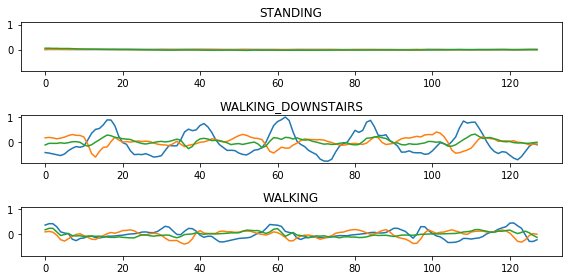

In [6]:
def plot_samples(data_lst:[[np.array]], labels:[str]) -> None:
    fig, axs = plt.subplots(len(data_lst), figsize=(8, 4), sharey=True)
    for i in range(len(data_lst)):
        # Plot-wise loop
        for j in range(len(data_lst[i])):
            axs[i].plot(data_lst[i][j])
        axs[i].set_title(labels[i])
    plt.tight_layout()
        
    
plot_samples([[uci_x_train[0][:,0], uci_x_train[0][:,1], uci_x_train[0][:,2]],
             [uci_x_train[4500][:,0], uci_x_train[4500][:,1], uci_x_train[4500][:,2]],
             [uci_x_train[2000][:,0], uci_x_train[2000][:,1], uci_x_train[2000][:,2]]],
            [onehot2label(uci_y_train[0]), onehot2label(uci_y_train[4500]), onehot2label(uci_y_train[2000])])
    

Finally, by transforming the dataset in the form of a _tf.Dataset_, it is possible to ease its manipulability for further operations.

In [7]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128
NUM_FEATURES = 9

har_train = tf.data.Dataset.from_tensor_slices((uci_x_train, uci_y_train))
har_train = har_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

har_val = tf.data.Dataset.from_tensor_slices((uci_x_test, uci_y_test))
har_val = har_val.cache().batch(BATCH_SIZE)

## Keras Model
The following script shows four functional models characterized by several factors, like network depth and thus the number of parameters, in order to experiment with different architectures.

Each network is composed of an initial __LSTM__ layer. The number of units in this layer characterizes the dimensionality of the output space, thus providing a more or less complicated abstract space.

Subsequently, a _Dense_ layer of __six__ units with _softmax_ activation function identifies each network's final layer. This layer's task is to generate a probability of the $n$ classes for each input sample.

$$\sigma(x)_i = \frac{e^{x_i}}{\sum_i e^{x_i}}$$

The optimization process minimizes the __Categorical Cross-Entropy__ loss function. This function produces a statistical value denoting the "difference" between two probabilities, namely the one observable through the sample's labels and the one produced by the model. Once the distance is sufficiently low, the model should correctly predict most of the samples in the validation set, provided that no significant bias affects the given training set.

$$\text{CE}(y, \sigma(x)) = -\sum_i y_i \log\sigma(x)_i$$

In [8]:
lstm_estimator_01 = tf.keras.models.Sequential()
lstm_estimator_02 = tf.keras.models.Sequential()
lstm_estimator_03 = tf.keras.models.Sequential()
lstm_estimator_04 = tf.keras.models.Sequential()

lstm_estimator_01.add(tf.keras.layers.LSTM(128))
lstm_estimator_01.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_01.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

lstm_estimator_02.add(tf.keras.layers.LSTM(512))
lstm_estimator_02.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_02.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

lstm_estimator_03.add(tf.keras.layers.LSTM(256))
lstm_estimator_03.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_estimator_03.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_03.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

lstm_estimator_04.add(tf.keras.layers.LSTM(128))
lstm_estimator_04.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_04.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

models = [lstm_estimator_01, lstm_estimator_02, lstm_estimator_03, lstm_estimator_04]

## Part 4 - Experimental evaluation


The following section comprehends the training phase for the presented models plus tests on the validation set.

An __Epoch__ defines an iteration on the whole training set [1]. Each network is allowed to run the training phase for at most $100$ epochs.  After each epoch, the training function tests the model by predicting a subset of samples from the validation set.

An EarlyStopping algorithm provided by the Tensorflow framework under the form of a callback guards the training phase, thus preventing any significant overfitting of the models.
This callback monitors the accuracy of the validation set at each epoch. If the model cannot achieve a better validation accuracy over $7$ epochs following the best one, then the training phase is stopped, and the algorithm restores the best model's parameters accordingly to the previous best epoch.

[1] : [https://keras.io/api/models/model_training_apis/#fit-method](https://keras.io/api/models/model_training_apis/#fit-method)

In [9]:
NUM_EPOCHS = 100
models_history = []
for i, model in enumerate(models):
    print(f'Starting training phase for model no. {i}...', end='')
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, restore_best_weights=True)
    hist = model.fit(har_train,
                     epochs=NUM_EPOCHS,
                     validation_data=har_val,
                     callbacks=[early_stopping_cb],
                     verbose=True)
    print('Completed.')
    model.save(f'model_{i}.md')
    models_history.append(hist)

Starting training phase for model no. 0...Epoch 1/100
58/58 [==============================] - 6s 112ms/step - loss: 1.2828 - acc: 0.4563 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/100
58/58 [==============================] - 4s 65ms/step - loss: 0.8772 - acc: 0.6311 - val_loss: 0.8530 - val_acc: 0.6712
Epoch 3/100
58/58 [==============================] - 4s 65ms/step - loss: 0.6873 - acc: 0.7189 - val_loss: 0.7102 - val_acc: 0.7302
Epoch 4/100
58/58 [==============================] - 4s 65ms/step - loss: 0.5362 - acc: 0.7961 - val_loss: 0.6132 - val_acc: 0.7591
Epoch 5/100
58/58 [==============================] - 4s 65ms/step - loss: 0.4306 - acc: 0.8478 - val_loss: 0.4969 - val_acc: 0.8208
Epoch 6/100
58/58 [==============================] - 4s 65ms/step - loss: 0.3246 - acc: 0.8876 - val_loss: 0.3876 - val_acc: 0.8683
Epoch 7/100
58/58 [==============================] - 4s 65ms/step - loss: 0.2464 - acc: 0.9113 - val_loss: 0.4304 - val_acc: 0.8466
Epoch 8/100
58/58 [======

Once the training phase ends, it is possible to plot the training history by querying the resulting structure for both accuracy and loss compared to the training and validation sets. The following function plots the resulting elements for the three models.

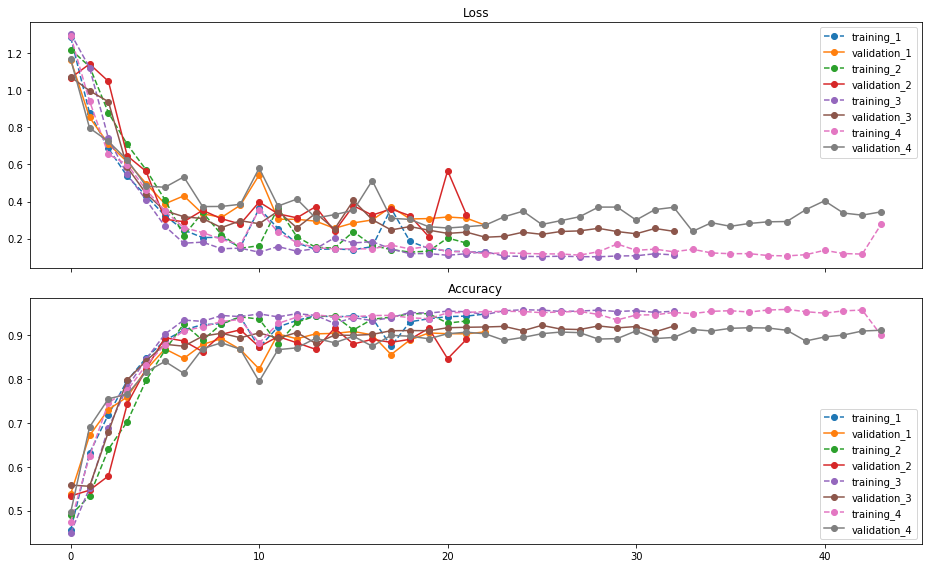

In [14]:
def plot_models_result(history: [tf.keras.callbacks.History]) -> None:
    fig, axs = plt.subplots(2, figsize=(13, 8), sharex=True)
    for i, hist in enumerate(history):
        axs[0].plot(hist.history['loss'], '--o', label=f'training_{i+1}')
        axs[0].plot(hist.history['val_loss'], '-o', label=f'validation_{i+1}')
        axs[1].plot(hist.history['acc'], '--o', label=f'training_{i+1}')
        axs[1].plot(hist.history['val_acc'], '-o', label=f'validation_{i+1}')
    axs[0].legend()
    axs[1].legend()
    axs[0].set_title('Loss')
    axs[1].set_title('Accuracy')
    plt.tight_layout()
    
plot_models_result(models_history)

Notice that neither of the models effectively reached $100$ epochs since the EarlyStop callback halted the training, preventing overfitting.

However, models perform better in the training phase respect to the validation one thus highlighting a partial overfit of the models 

It is crucial to keep in mind that accuracy does not yield enough information regarding the training quality. A relevant metric used in multiclass classification is the __Confusion Matrix__. The matrix's dimension is $n\times n$ if there are $n$ classes, and each element $x_{ij}$ represents how many samples of class $i$ are classified as class $j$.
The following function samples and predicts $10$ batches from the validation set and uses the results to build the confusion matrix for the selected model. The following plot shows the resulting confusion matrix for model $1$.

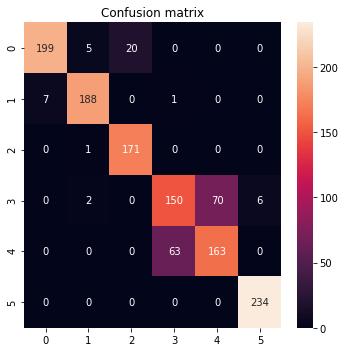

In [11]:
def plot_confusion_matrix(confusion_mat: np.array) -> None:
    fig, ax = plt.subplots(figsize=(5,5))
    df_cm = pd.DataFrame(confusion_mat.astype(np.int), range(NUM_CLASSES), range(NUM_CLASSES))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')
    ax.set_ylim(len(confusion_mat), 0.0)
    ax.set_title('Confusion matrix')
    

cm = np.zeros(shape=(NUM_CLASSES, NUM_CLASSES))
for x_val, y_val in har_val.take(10):
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(models[2].predict(x_val), axis=1)
    tcm = confusion_matrix(y_true, y_pred, labels=range(0, NUM_CLASSES))
    cm += tcm

plot_confusion_matrix(cm)
plt.tight_layout()
plt.show()

A performing model produces a fully diagonal confusion matrix. In this example, the overall quality of classification is reasonable. Notice a misclassification between classes $3$ and $4$, which corresponds to __SITTING__ and __STANDING__, respectively.

Another relevant metric to be considered regards the dimension of the model for its validation performance. The following plot shows the number of parameters for accuracy comparison of all the presented models.

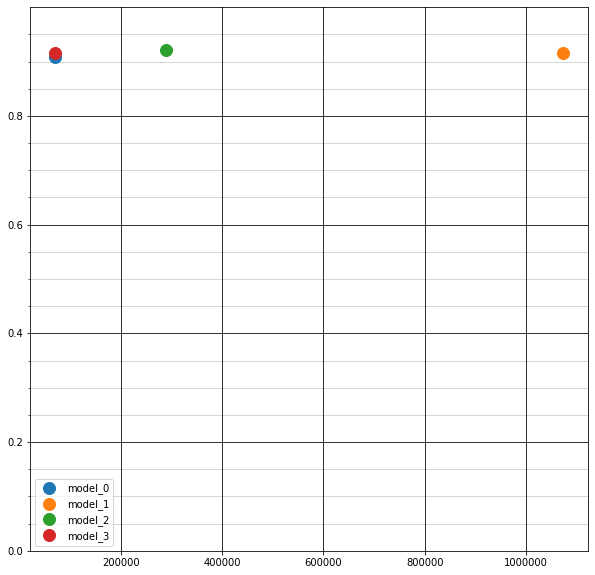

In [12]:
def count_params(model:tf.keras.models.Model) -> int:
    trainable_count = int(np.sum([tf.keras.backend.count_params(p) for p in list(model.trainable_weights)]))
    return trainable_count

fig, ax = plt.subplots(figsize=(10,10))
model_params = [count_params(m) for m in models]
max_accuracy = [np.max(h.history['val_acc']) for h in models_history]
#ax.plot(np.array(model_params), np.array(max_accuracy), 'x')
for i in range(len(model_params)):
    ax.plot(model_params[i], max_accuracy[i], 'o', label=f'model_{i}', markersize=12)
ax.set_yticks(np.arange(0, 1, 0.2))
ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
ax.set_facecolor('None')
ax.grid(True, which='both', color='black')
ax.grid(which='minor', alpha=0.2)
ax.legend()
ax.set_ylim(0, 1)
plt.show()

As shown 

In [13]:
pd.DataFrame(np.array(max_accuracy) / np.array(model_params), columns=['acc_params ratio'])

,acc_params ratio
0,1.271233e-05
1,8.539113e-07
2,3.187705e-06
3,1.283110e-05
